# Predictive Modelling

Let's import the data

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\leopa\Google Drive\Library\George Brown\II Semester\DATA PROJECT CAPSTONE PROJECT\Magid Capstone Project\Prediction_table.csv")

In [2]:
print('n rows:', df.shape[0], ', n col:',  df.shape[1])

n rows: 234925 , n col: 61


We are going to group by movie the following features, in order to have per eah movie the percentage of users in each segment : 

    - is_favorite: how many users selected it as favorite?
    - social_people_2: how many social watchers?
    - casual_viewer_2: how many casual watchers?
    - serious_2: how many serious watchers?
    - follower_2: how many follwers watchers?

We are also retrieving the average rating per movie, that is going to be our target variable

In [5]:
a = df.groupby('movie_id', as_index=False)['rating', 'is_favorite', 'social_people_2', 'casual_viewer_2', 'serious_2', 'follower_2',
       'freq'].mean()
a = a.rename(columns={"rating": "avg_rating", 
                      "is_favorite": "is_favorite_avg",
                     "social_people_2": "social_people",
                     "casual_viewer_2":"casual_viewer",
                     "serious_2":"serious",
                     "follower_2":"follower",
                     "freq":"freq_avg"})
a

<ipython-input-5-201185f818c9>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  a = df.groupby('movie_id', as_index=False)['rating', 'is_favorite', 'social_people_2', 'casual_viewer_2', 'serious_2', 'follower_2',


,movie_id,avg_rating,is_favorite_avg,social_people,casual_viewer,serious,follower,freq_avg
0,8984,4.284211,0.021053,0.410526,0.378947,0.442105,0.557895,0.947368
1,8985,4.175000,0.012500,0.312500,0.325000,0.162500,0.250000,0.737500
2,8986,3.896907,0.041237,0.185567,0.278351,0.237113,0.206186,0.835052
3,8987,3.800000,0.063158,0.242105,0.368421,0.189474,0.157895,0.842105
4,8988,4.225806,0.010753,0.365591,0.419355,0.387097,0.569892,1.000000
...,...,...,...,...,...,...,...,...
2613,13526,4.200000,0.231579,0.242105,0.010526,0.231579,0.063158,0.747368
2614,13527,4.395604,0.241758,0.186813,0.010989,0.285714,0.087912,0.593407
2615,13528,3.716981,0.075472,0.207547,0.018868,0.301887,0.056604,0.849057
2616,13529,4.289308,0.201258,0.251572,0.000000,0.245283,0.106918,0.761006


In [8]:
df = df.drop_duplicates()


In [9]:
df.shape

(2618, 54)

Now We just need to standardize numerical variable. 

We want to convert our X to a sparse matrix. Let's create a pipeline to do that.

Basically a sparse matrix is a matrix with a lot of 0s, and let most of the algorithms to save some computation time.

From Wikipedia:

Operations using standard dense-matrix structures and algorithms are slow and inefficient when applied to large sparse matrices as processing and memory are wasted on the zeros. Sparse data is by nature more easily compressed and thus requires significantly less storage. Some very large sparse matrices are infeasible to manipulate using standard dense-matrix algorithms.

In [10]:
df.drop(['movie_id', 'movie_name'], axis=1, inplace=True)
df['Final_Cluster'] = df['Final_Cluster'].astype(object)

X = df.drop(columns=['avg_rating'])
y = df.avg_rating

In [11]:
y.describe()

count    2618.000000
mean        3.964226
std         0.262663
min         2.979592
25%         3.788235
50%         3.952661
75%         4.153650
max         4.740741
Name: avg_rating, dtype: float64

In [12]:
y[y<4] = 0
y[y>=4] = 1

y.describe()

<ipython-input-12-1ed2f656489b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y<4] = 0
<ipython-input-12-1ed2f656489b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y>=4] = 1


count    2618.000000
mean        0.438885
std         0.496346
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: avg_rating, dtype: float64

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.base import TransformerMixin
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

scale= StandardScaler()


X_train, X_test_t, y_train, y_test_t = train_test_split(X, y, random_state=2, test_size = 0.5, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test_t, y_test_t, random_state=2, test_size = 0.4, stratify=y_test_t)


In [22]:
y_test.value_counts()

0.0    441
1.0    344
Name: avg_rating, dtype: int64

In [23]:
y_val.value_counts()

0.0    294
1.0    230
Name: avg_rating, dtype: int64

In [24]:
class SparseMatrix(TransformerMixin):
    def __init__(self):
        None
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        categorical_columns= X.columns[X.dtypes==object].tolist()
        ohe = OneHotEncoder() 
        hot = ohe.fit_transform(X[categorical_columns])
        cold_df = X.select_dtypes(exclude=["object"])
        cold_df = scale.fit_transform(cold_df) 
        cold = csr_matrix(cold_df)
        final_sparse_matrix = hstack((hot, cold))
        final_csr_matrix = final_sparse_matrix.tocsr()
        return final_csr_matrix

In [25]:
X_train_transformed = SparseMatrix().fit_transform(X_train)
print(X_train_transformed)

  (0, 7)	1.0
  (0, 9)	-0.9617618689074791
  (0, 10)	-0.5886912018333011
  (0, 11)	-0.9996411172603092
  (0, 12)	-0.7283231424435357
  (0, 13)	-0.8852557841485358
  (0, 14)	-0.6239841109507226
  (0, 15)	-0.7747174643587889
  (0, 16)	-0.5816113825031005
  (0, 17)	-0.4809355891726493
  (0, 18)	-0.5260841530428996
  (0, 19)	-0.10049999271958715
  (0, 20)	-1.0740382754147844
  (0, 21)	-1.0973509178449665
  (0, 22)	0.8680040513828594
  (0, 23)	-0.28268166679161233
  (0, 24)	-0.29509745350028344
  (0, 25)	-0.4794710827096176
  (0, 26)	-0.4173904435942119
  (0, 27)	0.5880959354010774
  (0, 28)	-0.3361635284613052
  (0, 29)	-0.657894710356828
  (0, 30)	-0.7086859861264808
  (0, 31)	-1.3973912415626129
  (0, 32)	1.3672083053726223
  :	:
  (1308, 34)	-1.0029663995807632
  (1308, 35)	-1.1084350624410155
  (1308, 36)	-0.910149852083526
  (1308, 37)	-0.47034319482601167
  (1308, 38)	0.07886893026815361
  (1308, 39)	0.8734514112185666
  (1308, 40)	-0.4423767174019015
  (1308, 41)	1.430130130840224
  

In [26]:
sm_df = pd.DataFrame(X_train_transformed.toarray())
sm_df.head()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.961762,...,-1.028440,-0.746234,-0.737108,-0.474733,-0.346633,-0.907908,1.310393,-0.719159,-1.293074,0.054625
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.868951,...,1.406816,-0.658306,2.047529,-1.231976,1.337281,-0.875911,-1.910414,-0.833219,0.062272,-1.953217
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.604597,...,-0.147518,-0.179475,-0.131252,0.611837,-0.199544,2.497163,-0.039778,0.586773,-0.420285,0.519995
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.348182,...,-0.535627,-0.388456,-1.007418,0.204020,-1.024876,-0.989304,0.003917,-0.530448,-0.099664,0.482101
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.609713,...,-0.525835,-0.236987,-0.502130,-0.310457,3.004686,-3.117074,-3.064784,-2.407458,-1.665046,-7.103401


In [27]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [28]:
# Import GridSearchCV
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

In [29]:
def cross_val(model):
    scores = cross_val_score(model, X_train_transformed, y_train, scoring='accuracy', cv=kfold)
    rmse = (-scores.mean())
    return rmse

In [30]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

In [31]:
def grid_search(params, reg=XGBClassifier(objective='binary:logistic')):
    grid_reg = GridSearchCV(reg, params, scoring='accuracy', cv=kfold)
    grid_reg.fit(X_train_transformed, y_train)
    best_params = grid_reg.best_params_
    print("Best params:", best_params)
    best_score = np.sqrt(-grid_reg.best_score_)
    print("Best score:", best_score)

In [32]:
def Rgrid_search(params, reg=XGBClassifier(objective='binary:logistic')):
    grid_reg = RandomizedSearchCV(reg, params, scoring='neg_mean_squared_error', cv=kfold)
    grid_reg.fit(X_train_transformed, y_train)
    best_params = grid_reg.best_params_
    print("Best params:", best_params)
    best_score = np.sqrt(-grid_reg.best_score_)
    print("Best score:", best_score)

In [33]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', eval_metric='logloss', random_state=2)

In [34]:
# Import cross_val_score
from sklearn.model_selection import cross_val_score

# Import numpy
import numpy as np

# Obtain scores of cross-validation
scores = cross_val_score(model, X_train_transformed, y_train, cv=5)

# Display accuracy
print('Accuracy:', np.round(scores, 2))

# Display mean accuracy
print('Accuracy mean: %0.2f' % (scores.mean()))

C:\Users\leopa\anaconda3\envs\Python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\leopa\anaconda3\envs\Python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\leopa\anaconda3\envs\Python\lib\site-packages\xgboost\sklearn

Accuracy: [0.83 0.84 0.82 0.81 0.83]
Accuracy mean: 0.83


In [35]:
def grid_search(params, random=False): 
    
    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=2)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=20, n_jobs=-1, random_state=2)
    else:
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)
    
    # Fit grid_reg on X_train and y_train
    grid.fit(X_train_transformed, y_train)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))

## Tuning

In [47]:
grid_search(params={'n_estimators':[100, 200, 400, 800]})

C:\Users\leopa\anaconda3\envs\Python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:46:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'n_estimators': 100}
Best score: 0.82750


In [48]:
grid_search(params={'n_estimators':[100],
                    'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]})

C:\Users\leopa\anaconda3\envs\Python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:47:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'learning_rate': 0.2, 'n_estimators': 100}
Best score: 0.83351


In [52]:
grid_search(params={'n_estimators':[100],
                    'learning_rate':[0.2],
                    'max_depth':[2, 3, 5, 6, 8],
                    'gamma':[0, 0.01, 0.1, 0.5, 1, 2]})

C:\Users\leopa\anaconda3\envs\Python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:51:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'gamma': 0.01, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Best score: 0.83787


In [56]:
grid_search(params={'n_estimators':[100],
                    'learning_rate':[0.2],
                    'max_depth':[5],
                    'gamma': [0.01],
                    'subsample':[0.6, 0.7, 0.8],
                    'colsample_bytree':[0.4,0.5,0.6]})

C:\Users\leopa\anaconda3\envs\Python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:56:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'colsample_bytree': 0.5, 'gamma': 0.01, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.6}
Best score: 0.84115


In [36]:
grid_search(params={'n_estimators':[100],
                    'learning_rate':[0.2],
                    'max_depth':[5],
                    'gamma': [0.01],
                    'subsample':[0.6],
                    'colsample_bytree':[0.5]})

C:\Users\leopa\anaconda3\envs\Python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'colsample_bytree': 0.5, 'gamma': 0.01, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.6}
Best score: 0.81208


### Model Evaluation on test set

In [42]:
from sklearn.metrics import mean_absolute_error

In [43]:
X_train_transformed = SparseMatrix().fit_transform(X_train)

In [44]:
X_test_transformed = SparseMatrix().fit_transform(X_test)

In [45]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=2,
                     n_estimators = 100,
                     learning_rate = 0.2,
                     max_depth = 5,
                     gamma = 0.01,
                     subsample = 0.6,
                     colsample_bytree=0.5)
eval_set = [(X_test_transformed, y_test)]
eval_metric='error'
model.fit(X_train_transformed, y_train, eval_metric=eval_metric, eval_set=eval_set, early_stopping_rounds=10)
# make predictions for test data
y_pred = model.predict(X_test_transformed)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.27006
[1]	validation_0-error:0.22548
[2]	validation_0-error:0.22803
[3]	validation_0-error:0.21401
[4]	validation_0-error:0.21146
[5]	validation_0-error:0.21529
[6]	validation_0-error:0.20764
[7]	validation_0-error:0.20127
[8]	validation_0-error:0.19745
[9]	validation_0-error:0.19490
[10]	validation_0-error:0.18981
[11]	validation_0-error:0.18726
[12]	validation_0-error:0.18854
[13]	validation_0-error:0.19108
[14]	validation_0-error:0.19236
[15]	validation_0-error:0.18981
[16]	validation_0-error:0.18981
[17]	validation_0-error:0.18726
[18]	validation_0-error:0.18726
[19]	validation_0-error:0.17834


C:\Users\leopa\anaconda3\envs\Python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-error:0.18599
[21]	validation_0-error:0.18726
[22]	validation_0-error:0.18471
[23]	validation_0-error:0.17962
[24]	validation_0-error:0.17580
[25]	validation_0-error:0.17962
[26]	validation_0-error:0.17452
[27]	validation_0-error:0.17707
[28]	validation_0-error:0.17580
[29]	validation_0-error:0.18089
[30]	validation_0-error:0.17707
[31]	validation_0-error:0.17707
[32]	validation_0-error:0.17197
[33]	validation_0-error:0.17325
[34]	validation_0-error:0.16815
[35]	validation_0-error:0.17070
[36]	validation_0-error:0.16688
[37]	validation_0-error:0.17070
[38]	validation_0-error:0.17325
[39]	validation_0-error:0.16815
[40]	validation_0-error:0.17580
[41]	validation_0-error:0.17962
[42]	validation_0-error:0.17452
[43]	validation_0-error:0.17197
[44]	validation_0-error:0.16943
[45]	validation_0-error:0.17197
[46]	validation_0-error:0.17070
Accuracy: 83.31%


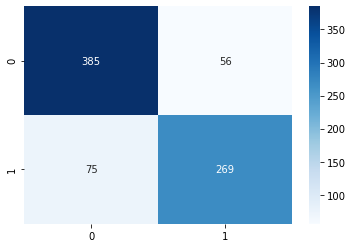

In [46]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')

## model evaluation on validation set

In [47]:
X_val_transformed = SparseMatrix().fit_transform(X_val)

In [48]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=2,
                     n_estimators = 100,
                     learning_rate = 0.2,
                     max_depth = 5,
                     gamma = 0.01,
                     subsample = 0.6,
                     colsample_bytree=0.5)
eval_set = [(X_train_transformed, y_train)]
eval_metric='error'
model.fit(X_train_transformed, y_train, eval_metric=eval_metric, eval_set=eval_set, early_stopping_rounds=10)
# make predictions for test data
y_pred = model.predict(X_val_transformed)
# evaluate predictions
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.21543
[1]	validation_0-error:0.15432
[2]	validation_0-error:0.14286
[3]	validation_0-error:0.12070
[4]	validation_0-error:0.11612
[5]	validation_0-error:0.11383
[6]	validation_0-error:0.10924
[7]	validation_0-error:0.09931
[8]	validation_0-error:0.10084
[9]	validation_0-error:0.10160
[10]	validation_0-error:0.09244
[11]	validation_0-error:0.08632
[12]	validation_0-error:0.08021
[13]	validation_0-error:0.07869
[14]	validation_0-error:0.07563
[15]	validation_0-error:0.07257
[16]	validation_0-error:0.06799
[17]	validation_0-error:0.06494
[18]	validation_0-error:0.06188


C:\Users\leopa\anaconda3\envs\Python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-error:0.05959
[20]	validation_0-error:0.05882
[21]	validation_0-error:0.05730
[22]	validation_0-error:0.05806
[23]	validation_0-error:0.05195
[24]	validation_0-error:0.04736
[25]	validation_0-error:0.04507
[26]	validation_0-error:0.04431
[27]	validation_0-error:0.04660
[28]	validation_0-error:0.04431
[29]	validation_0-error:0.04125
[30]	validation_0-error:0.03896
[31]	validation_0-error:0.03514
[32]	validation_0-error:0.03514
[33]	validation_0-error:0.02979
[34]	validation_0-error:0.02903
[35]	validation_0-error:0.02827
[36]	validation_0-error:0.02445
[37]	validation_0-error:0.02368
[38]	validation_0-error:0.02292
[39]	validation_0-error:0.01986
[40]	validation_0-error:0.02215
[41]	validation_0-error:0.01757
[42]	validation_0-error:0.01757
[43]	validation_0-error:0.01986
[44]	validation_0-error:0.01604
[45]	validation_0-error:0.01528
[46]	validation_0-error:0.01299
[47]	validation_0-error:0.00993
[48]	validation_0-error:0.01146
[49]	validation_0-error:0.00917
[50]	val

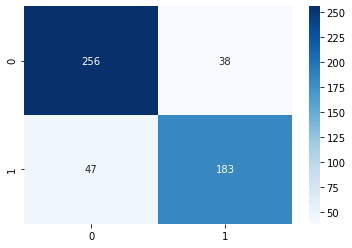

In [49]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_val, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')

### XGBoost Feature importance

XGboost is basically a DecisionTree ensemble.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

[0.         0.00435545 0.0121394  0.         0.         0.02717895
 0.         0.01539566 0.00793658 0.01466941 0.03119546 0.01866295
 0.01099052 0.01013612 0.01542765 0.01482716 0.02026839 0.01642813
 0.01559337 0.03339575 0.01275978 0.01606703 0.01293919 0.02468523
 0.01083994 0.01046736 0.01358363 0.01880948 0.01339401 0.01285016
 0.01774981 0.02298987 0.01246637 0.02451786 0.01131003 0.02339466
 0.02718531 0.01726932 0.01481911 0.01059641 0.01018347 0.01828236
 0.01609265 0.02134658 0.01867654 0.01854447 0.01035818 0.04312115
 0.02920661 0.04740239 0.01490732 0.01630784 0.01220862 0.0409365
 0.01070424 0.0110369  0.03057816 0.01790721 0.01490325]


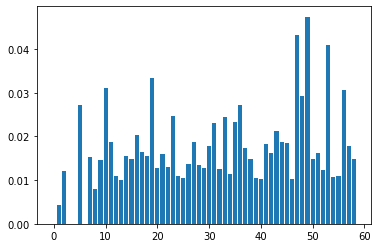

In [50]:
from matplotlib import pyplot

print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [51]:
pd.set_option('display.max_columns', None)

sm_df = pd.DataFrame(X_train_transformed.toarray())


In [52]:
from scipy.sparse import csr_matrix
from scipy.sparse import hstack    
    
categorical_columns= X.columns[X.dtypes==object].tolist()
ohe = OneHotEncoder() 
hot = ohe.fit_transform(X[categorical_columns])
cold_df = X.select_dtypes(exclude=["object"])
cold = csr_matrix(cold_df)
final_sparse_matrix = hstack((hot, cold))
final_csr_matrix = final_sparse_matrix.tocsr()

In [53]:
ohe.get_feature_names(categorical_columns)

array(['Final_Cluster_0', 'Final_Cluster_1', 'Final_Cluster_3',
       'Final_Cluster_4', 'Final_Cluster_5', 'Final_Cluster_6',
       'Final_Cluster_7', 'Final_Cluster_8', 'Final_Cluster_9'],
      dtype=object)

In [54]:
cold_df.columns

Index(['intelligent', 'real', 'touching', 'relatable', 'sad', 'romantic',
       'informative', 'mean', 'fake', 'glamorous', 'original', 'predictable',
       'fresh', 'mindless', 'unrelatable', 'imaginative', 'wholesome',
       'inspiring', 'shallow', 'edgy', 'fastpaced', 'disturbing', 'dramatic',
       'outrageous', 'exciting', 'calming', 'slow', 'unoriginal', 'uplifting',
       'sexy', 'deep', 'scary', 'thirlling_susp', 'fun_funny',
       'info_real_int_insp', 'fun_outrag_mindless',
       'fastpaced_thrilling_exciting', 'scary_dist_edgy_thrill',
       'origi_imagin_fresh_imag', 'sad_dramatic_deep_touching',
       'fake_unrel_unorig_predic', 'sexy_glam_rom',
       'touching_wholesome_uplifting', 'mean_edgy', 'is_favorite_avg',
       'social_people', 'casual_viewer', 'serious', 'follower', 'freq_avg'],
      dtype='object')

In [56]:
column_names = ["Variables", "Importance"]

imp = pd.DataFrame(columns = column_names)  
imp["Variables"] = variables
imp["Importance"] = model.feature_importances_
imp = imp.sort_values(by=['Importance'], ascending=False)
imp.head(10)

,Variables,Importance
49,fake_unrel_unorig_predic,0.047402
47,origi_imagin_fresh_imag,0.043121
53,is_favorite_avg,0.040937
19,original,0.033396
10,real,0.031195
56,serious,0.030578
48,sad_dramatic_deep_touching,0.029207
36,unoriginal,0.027185
5,Final_Cluster_6,0.027179
23,unrelatable,0.024685


In [58]:
# reorder the predicted values in descending order and calculate the cumulative sum
pred_v = pd.Series(y_pred)
pred_v = pred_v.sort_values(ascending=False)
pred_v

262    1.0
212    1.0
418    1.0
192    1.0
194    1.0
      ... 
228    0.0
226    0.0
221    0.0
220    0.0
523    0.0
Length: 524, dtype: float64

Text(0.5, 1.0, 'Cumulative Gains Chart')

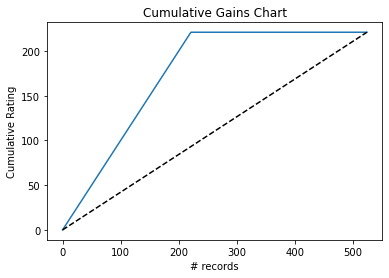

In [59]:
from dmba import regressionSummary, classificationSummary, liftChart, gainsChart

ax = gainsChart(pred_v)
ax.set_ylabel('Cumulative Rating')
ax.set_title('Cumulative Gains Chart')

Text(0, 0.5, 'Lift')

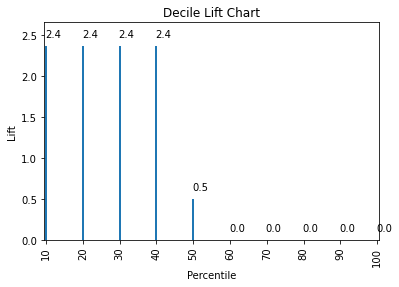

In [60]:
ax = liftChart(pred_v)
ax.set_ylabel('Lift')